The notebook determines the topology and required slices of the visible portion
of the result. Since a small portion of the latitude extent is visible, a significant
portion of the data can be ignored.

The code in this notebook is made available under the [GPLv2 license](../LICENSE.md).

In [1]:
import itertools
import os
from collections import defaultdict
from enum import IntEnum

import numpy as np

# Plotting
%matplotlib nbagg
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

# For azimuth and distance calculations.
from geographiclib.geodesic import Geodesic

# To read the CMTSOLUTION file.
from obspy import read_events

In [2]:
# Some values from constants.h
R_EARTH = 6371000
R_EARTH_KM = R_EARTH / 1000
FLATTENING_F = 1.0 / 299.8e0
ONE_MINUS_F_SQUARED = (1.0 - FLATTENING_F)**2
FACTOR_TAN = 1.0 / ONE_MINUS_F_SQUARED
TINYVAL = 1.0e-9

In [3]:
# Chunk numbering and colours.
Chunk = IntEnum('Chunk', 'AB AC BC AC_ANTIPODE BC_ANTIPODE AB_ANTIPODE')

Set1 = plt.get_cmap('Set1', lut=9)
CHUNK_COLORS = [Set1(i) for i in range(9)]

In [4]:
# NOTE: The mesh should be the same no matter which method is used.
BASEDIR = 'DATA'

In [5]:
# We only need mesh information, so it doesn't matter which of these is used.
cmt = os.path.join(BASEDIR, 'CMTSOLUTION_Love')
sta = os.path.join(BASEDIR, 'STATIONS')
parfile = os.path.join(BASEDIR, 'Par_file_FA')

# Load simulation information

In [6]:
# Obtain simulation parameters
config = {}
with open(parfile, 'r') as f:
    for line in f:
        line = line.split('#')[0]
        if not line:
            continue
        line = line.strip()
        if not line:
            continue

        var, value = [x.strip() for x in line.split('=', maxsplit=1)]
        config[var] = value

NCHUNKS = int(config['NCHUNKS'])
NPROC_XI = int(config['NPROC_XI'])
NPROC_ETA = int(config['NPROC_ETA'])
print("NCHUNKS = %d, NPROC_XI = %d, NPROC_ETA = %d" % (NCHUNKS, NPROC_XI, NPROC_ETA))
if NCHUNKS != 6:
    ANGULAR_WIDTH_XI_IN_DEGREES = float(config['ANGULAR_WIDTH_XI_IN_DEGREES'].replace('d', 'e'))
    ANGULAR_WIDTH_ETA_IN_DEGREES = float(config['ANGULAR_WIDTH_ETA_IN_DEGREES'].replace('d', 'e'))
    CENTER_LATITUDE_IN_DEGREES = float(config['CENTER_LATITUDE_IN_DEGREES'].replace('d', 'e'))
    CENTER_LONGITUDE_IN_DEGREES = float(config['CENTER_LONGITUDE_IN_DEGREES'].replace('d', 'e'))
    GAMMA_ROTATION_AZIMUTH = float(config['GAMMA_ROTATION_AZIMUTH'].replace('d', 'e'))
    print("xi_width = %f, eta_width = %f; clat = %f, clon = %f; grot = %f" % (
        ANGULAR_WIDTH_XI_IN_DEGREES, ANGULAR_WIDTH_ETA_IN_DEGREES,
        CENTER_LATITUDE_IN_DEGREES, CENTER_LONGITUDE_IN_DEGREES, GAMMA_ROTATION_AZIMUTH))
else:
    ANGULAR_WIDTH_XI_IN_DEGREES = ANGULAR_WIDTH_ETA_IN_DEGREES = 90.0
    CENTER_LATITUDE_IN_DEGREES = CENTER_LONGITUDE_IN_DEGREES = GAMMA_ROTATION_AZIMUTH = None

ANGULAR_WIDTH_XI_RAD = np.deg2rad(ANGULAR_WIDTH_XI_IN_DEGREES)
ANGULAR_WIDTH_ETA_RAD = np.deg2rad(ANGULAR_WIDTH_ETA_IN_DEGREES)

NCHUNKS = 6, NPROC_XI = 8, NPROC_ETA = 8


In [7]:
# Obtain event location
origin = read_events(cmt, format='CMTSOLUTION')[0].preferred_origin()
event_lat = origin.latitude
event_lon = origin.longitude

In [8]:
# Obtain station location
data = np.genfromtxt(sta)
if data.ndim != 1:
    raise ValueError('ERROR: STATIONS files "%s" should contain only one '
                     'station!' % (sta, ))
station_lat = data[2]
station_lon = data[3]

In [9]:
print("event = (%f,%f);  station = (%f,%f)" % (event_lat, event_lon, station_lat, station_lon))

event = (0.000000,0.000000);  station = (0.000000,60.000000)


# Load addressing

In [10]:
slice_data = np.genfromtxt('DATA/addressing.txt', dtype=np.int_)
addressing = np.empty((NCHUNKS, NPROC_XI, NPROC_ETA), dtype=np.int_)
addressing[slice_data[:, 1] - 1, slice_data[:, 2], slice_data[:, 3]] = slice_data[:, 0]

# Find corners of every slice 

## 1 corner -> 4 corners

In [11]:
corner_data = np.repeat(slice_data, 4, axis=0)
corner_data[1::4, 2] += 1
corner_data[2::4, 2] += 1
corner_data[2::4, 3] += 1
corner_data[3::4, 3] += 1

In [12]:
corner_data[:10, :]

array([[0, 1, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 2, 0],
       [1, 1, 2, 1],
       [1, 1, 1, 1],
       [2, 1, 2, 0],
       [2, 1, 3, 0]])

## Convert corners to lat/lon

In [13]:
def rotmat(clat, clon, grot):
    """
    Calculate the 3x3 rotation matrix from the AB chunk
    frame to the actual frame defined by (clat,clon,grot).
    """

    # Compute colatitude and longitude
    alpha = np.deg2rad(clon)
    beta = np.pi / 2 - np.deg2rad(clat)
    gamma = np.deg2rad(grot)

    sina = np.sin(alpha)
    cosa = np.cos(alpha)
    sinb = np.sin(beta)
    cosb = np.cos(beta)
    sing = np.sin(gamma)
    cosg = np.cos(gamma)

    # define rotation matrix
    rotation_matrix = np.array([
        [cosg * cosb * cosa - sing * sina, -sing * cosb * cosa - cosg * sina, sinb * cosa],
        [cosg * cosb * sina + sing * cosa, -sing * cosb * sina + cosg * cosa, sinb * sina],
        [-cosg * sinb, sing * sinb, cosb]
    ])

    return rotation_matrix

In [14]:
# This algorithm originates in src/meshfem3D/compute_coordinates_grid.f90
# from specfem3d_globe.

islice = corner_data[:, 0]
ichunk = corner_data[:, 1]
iproc_xi = corner_data[:, 2]
iproc_eta = corner_data[:, 3]

ratio_xi = iproc_xi / NPROC_XI
x = 2 * ratio_xi - 1

ratio_eta = iproc_eta / NPROC_ETA
y = 2 * ratio_eta - 1

x = np.tan((ANGULAR_WIDTH_XI_RAD / 2) * x)
y = np.tan((ANGULAR_WIDTH_ETA_RAD / 2) * y)

xelem = np.empty(len(corner_data))
yelem = np.empty_like(xelem)
zelem = np.empty_like(xelem)

# define the mesh points on the top in the six regions of the cubed sphere
mask = ichunk == Chunk.AB
xelem[mask] = -y[mask]
yelem[mask] = x[mask]
zelem[mask] = 1

mask = ichunk == Chunk.AB_ANTIPODE
xelem[mask] = -y[mask]
yelem[mask] = -x[mask]
zelem[mask] = -1

mask = ichunk == Chunk.AC
xelem[mask] = -y[mask]
yelem[mask] = -1
zelem[mask] = x[mask]

mask = ichunk == Chunk.AC_ANTIPODE
xelem[mask] = -y[mask]
yelem[mask] = 1
zelem[mask] = -x[mask]
            
mask = ichunk == Chunk.BC
xelem[mask] = -1
yelem[mask] = y[mask]
zelem[mask] = x[mask]

mask = ichunk == Chunk.BC_ANTIPODE
xelem[mask] = 1
yelem[mask] = -y[mask]
zelem[mask] = x[mask]

if np.any(ichunk < 1) or np.any(ichunk > 6):
     raise ValueError('Incorrect chunk number in addressing.txt')

In [15]:
# rotate the chunk to the right location if we do not mesh the full Earth
if NCHUNKS != 6:
    rotation_matrix = rotmat(CENTER_LATITUDE_IN_DEGREES, CENTER_LONGITUDE_IN_DEGREES, GAMMA_ROTATION_AZIMUTH)
    vector = np.empty((len(xelem), 3))
    vector[:, 0] = xelem
    vector[:, 1] = yelem
    vector[:, 2] = zelem
    vector = np.dot(vector, rotation_matrix.T)
    xelem = vector[:, 0]
    yelem = vector[:, 1]
    zelem = vector[:, 2]

In [16]:
thetaelem = np.arctan2(np.hypot(xelem, yelem), zelem)
phielem = np.arctan2(yelem, xelem)
phielem[phielem < 0] += 2 * np.pi
thetastore = np.arctan(FACTOR_TAN * np.cos(thetaelem) / np.maximum(TINYVAL, np.sin(thetaelem)))

latelem = 90 - np.rad2deg(thetaelem)
lonelem = np.rad2deg(phielem)

# Plot slices

In [17]:
def plot_slices(ax, slices_by_chunk, show_boundary=True):
    patches = []
    valid_names = []
    for item, color in zip(Chunk, CHUNK_COLORS):
        for slice_number in slices_by_chunk[item]:
            mask = corner_data[:, 0] == slice_number
            lat = latelem[mask]
            lon = lonelem[mask]
            xy = np.column_stack((lon, lat))
            patch = mpatches.Polygon(xy,
                                     facecolor=color,
                                     transform=ccrs.Geodetic())
            ax.add_patch(patch)

            # Special handling at poles:
            if np.any(lat == 90) or np.any(lat == -90):
                # Find the diagonal point:
                mask = lon % 90 != 0
                lon = lon[mask]
                lat = [np.copysign(90, lat[mask]), lat[mask]]
            elif np.ptp(lon) >= 180:
                # 0 and 360 are ambiguous...
                lon[lon == 0] = 360
            # Label the slice.
            ax.text(np.average(lon), np.average(lat), str(slice_number),
                    fontsize=8, horizontalalignment='center', verticalalignment='center',
                    transform=ccrs.Geodetic())

        if len(slices_by_chunk[item]):
            patches.append(patch)
            valid_names.append(item.name)

    ax.legend(patches, valid_names, loc='lower left')

## All slices

In [18]:
all_slices_by_chunk = defaultdict(list)
for slice_number, chunk_id, nproc_xi, nproc_eta in slice_data:
    all_slices_by_chunk[Chunk(chunk_id)].append(slice_number)

In [19]:
all_slices_by_chunk

defaultdict(<class 'list'>, {<Chunk.AB: 1>: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], <Chunk.AC: 2>: [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127], <Chunk.BC: 3>: [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191], <Chunk.AC_ANTIPODE: 4>: [192, 193, 194, 195, 196, 197, 198, 199, 200, 

In [20]:
geod = Geodesic(R_EARTH, FLATTENING_F)
info = geod.Inverse(event_lat, event_lon, station_lat, station_lon)
central_point = geod.Direct(info['lat1'], info['lon1'], info['azi1'], info['s12'] / 2)
central_point

{'a12': 30.1004016064257,
 'azi1': 90.0,
 'azi2': 90.0,
 'lat1': 0.0,
 'lat2': 0.0,
 'lon1': 0.0,
 'lon2': 29.999999999999996,
 's12': 3335847.7993367617}

<IPython.core.display.Javascript object>


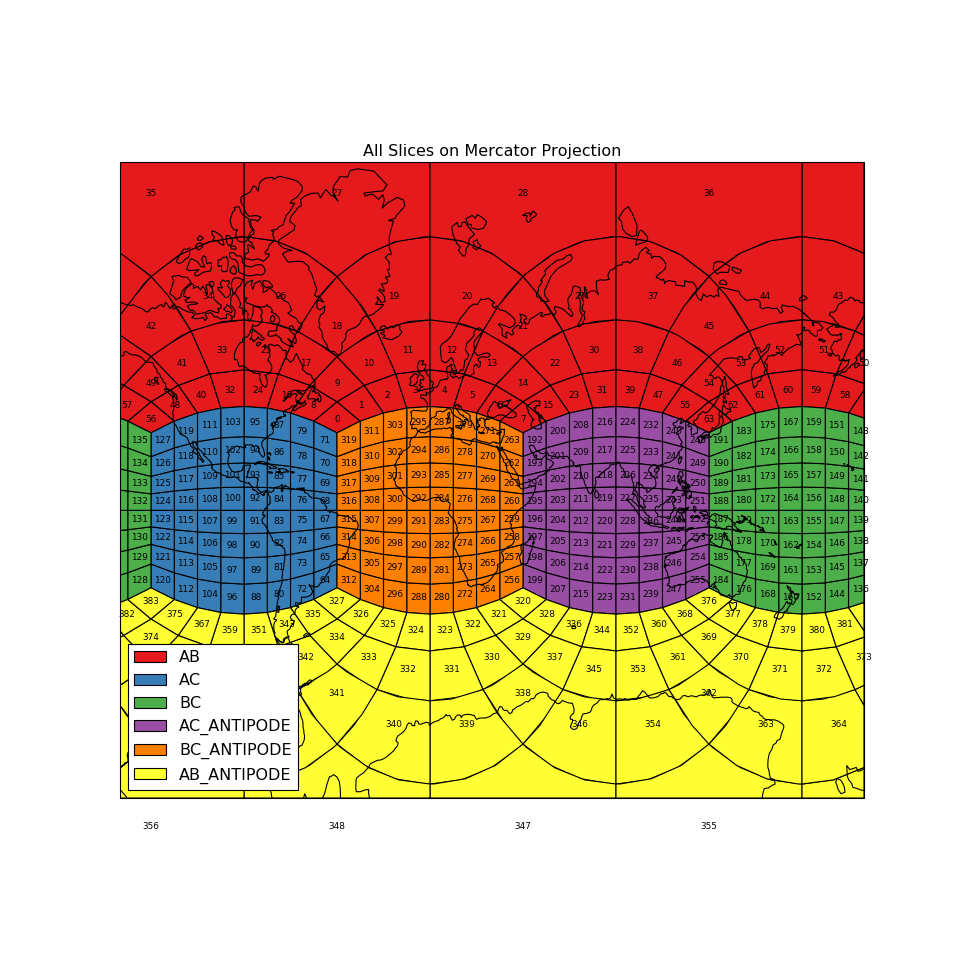

In [21]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.Mercator(central_longitude=central_point['lon2']))
ax.set_global()
ax.coastlines()
plot_slices(ax, all_slices_by_chunk)
ax.set_title('All Slices on Mercator Projection');

# Lay slices out in grid

In [22]:
# (Chunk ID, rotation (in multiples of 90), x-location, y-location)
eq_chunk_layout = [
    # Centre
    (Chunk.AC, 0, 0, 1),
    # Left
    (Chunk.BC_ANTIPODE, 0, 0, 0),
    # Right
    (Chunk.BC, 0, 0, 2),
    # Opposite (far-right)
    (Chunk.AC_ANTIPODE, 2, 0, 3),
]

In [23]:
slice_grid = np.empty((NPROC_XI, 4 * NPROC_ETA), dtype=np.int_)
slice_grid.fill(-1)
slice_rotations = np.zeros_like(slice_grid)

In [24]:
chunk_start = {k: min(v) for k, v in all_slices_by_chunk.items()}
chunk_size = NPROC_XI * NPROC_ETA

chunks = []
for chunk_id, rot, i, j in eq_chunk_layout:
    chunk = -np.ones((NPROC_XI, NPROC_ETA), dtype=np.int_)
    for slice_number in all_slices_by_chunk[chunk_id]:
        # Top-to-bottom, left-to-right
        x = (slice_number - chunk_start[chunk_id]) % NPROC_XI
        y = (slice_number - chunk_start[chunk_id]) // NPROC_XI
        chunk[x, y] = slice_number
    
    slice_grid[i * NPROC_XI:(i + 1) * NPROC_XI,
               j * NPROC_ETA:(j + 1) * NPROC_ETA] = np.rot90(chunk, rot)
    slice_rotations[i * NPROC_XI:(i + 1) * NPROC_XI,
                    j * NPROC_ETA:(j + 1) * NPROC_ETA] = rot

In [25]:
np.set_printoptions(linewidth=200)
print(slice_grid)

[[256 264 272 280 288 296 304 312  64  72  80  88  96 104 112 120 128 136 144 152 160 168 176 184 255 247 239 231 223 215 207 199]
 [257 265 273 281 289 297 305 313  65  73  81  89  97 105 113 121 129 137 145 153 161 169 177 185 254 246 238 230 222 214 206 198]
 [258 266 274 282 290 298 306 314  66  74  82  90  98 106 114 122 130 138 146 154 162 170 178 186 253 245 237 229 221 213 205 197]
 [259 267 275 283 291 299 307 315  67  75  83  91  99 107 115 123 131 139 147 155 163 171 179 187 252 244 236 228 220 212 204 196]
 [260 268 276 284 292 300 308 316  68  76  84  92 100 108 116 124 132 140 148 156 164 172 180 188 251 243 235 227 219 211 203 195]
 [261 269 277 285 293 301 309 317  69  77  85  93 101 109 117 125 133 141 149 157 165 173 181 189 250 242 234 226 218 210 202 194]
 [262 270 278 286 294 302 310 318  70  78  86  94 102 110 118 126 134 142 150 158 166 174 182 190 249 241 233 225 217 209 201 193]
 [263 271 279 287 295 303 311 319  71  79  87  95 103 111 119 127 135 143 151 159 1

In [26]:
print(slice_rotations)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2]]


In [27]:
np.savez_compressed('slices', grid=slice_grid, rotation=slice_rotations)

# License Statement
Copyright (C) 2016  Elliott Sales de Andrade

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.